## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, brier_score_loss
import time
import json
import re
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn import datasets
import graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, HistGradientBoostingRegressor
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.tree import plot_tree
import rdata

In [21]:
import DHL_Data_Challenge_Functions
from DHL_Data_Challenge_Functions import *

## Read data 

In [2]:
dfs = [_ for x in range(14)]

In [3]:
%%time
for i in range(1,10):
    path = '31622-000' + str(i) + '-Data.rda'
    datafile_tmp = rdata.read_rda(path)
    print(i,path)
    df_tmp = datafile_tmp['da31622.000' + str(i)]
    dfs[i-1] = df_tmp.copy()

1 31622-0001-Data.rda
2 31622-0002-Data.rda
3 31622-0003-Data.rda
4 31622-0004-Data.rda
5 31622-0005-Data.rda
6 31622-0006-Data.rda
7 31622-0007-Data.rda
8 31622-0008-Data.rda
9 31622-0009-Data.rda
CPU times: total: 2min 18s
Wall time: 3min 9s


In [4]:
%%time
for j in range (10, 15):
    path = '31622-00' + str(j) + '-Data.rda'
    datafile_tmp = rdata.read_rda(path)
    print(j,path)
    df_tmp = datafile_tmp['da31622.00' + str(j)]
    dfs[j-1] = df_tmp.copy()

10 31622-0010-Data.rda
11 31622-0011-Data.rda
12 31622-0012-Data.rda
13 31622-0013-Data.rda
14 31622-0014-Data.rda
CPU times: total: 13.8 s
Wall time: 20.4 s


In [6]:
overlap = []
for i in range(1,13):
    for j in range(i+1,14):
        overlap_tmp = list(set(dfs[i].columns.to_list()) & set(dfs[j].columns.to_list()))
        if len(overlap_tmp) > 0:
            overlap.extend(overlap_tmp)

In [7]:
not_contained = []
for k in range (1,14):
    sus_col = list(set(dfs[0].columns.to_list()) & set(dfs[k].columns.to_list()))
    if len(sus_col) != len(dfs[k].columns.to_list()):
        not_contained.append(k)
        print("The number of overlap coloumns between dfs[0] and dfs[",k, "] is", len(sus_col), ", while there are", len(dfs[k].columns.to_list()), "columns in df",k)

The number of overlap coloumns between dfs[0] and dfs[ 3 ] is 4759 , while there are 4760 columns in df 3
The number of overlap coloumns between dfs[0] and dfs[ 6 ] is 1 , while there are 100 columns in df 6
The number of overlap coloumns between dfs[0] and dfs[ 7 ] is 1 , while there are 165 columns in df 7
The number of overlap coloumns between dfs[0] and dfs[ 9 ] is 1 , while there are 70 columns in df 9
The number of overlap coloumns between dfs[0] and dfs[ 10 ] is 1 , while there are 65 columns in df 10
The number of overlap coloumns between dfs[0] and dfs[ 12 ] is 1 , while there are 27 columns in df 12
The number of overlap coloumns between dfs[0] and dfs[ 13 ] is 1 , while there are 568 columns in df 13


In [8]:
over_lapped_col_0_3 = list(set(dfs[0].columns.to_list()) & set(dfs[3].columns.to_list()))
print("The columns that are in dfs[3] but are not included in dfs[0] is:", set(dfs[3].columns.to_list()) - set(over_lapped_col_0_3))

The columns that are in dfs[3] but are not included in dfs[0] is: {'D3A1_HM'}


In [9]:
assert len(overlap) == (13 * 12)/2

## Create Mega dataset

In [10]:
for i in not_contained:
    print("dfs[",i,"] length:", len(dfs[i]))
    print("unique IDNUM:", len(dfs[i]['IDNUM'].unique()))

dfs[ 3 ] length: 4898
unique IDNUM: 4898
dfs[ 6 ] length: 4898
unique IDNUM: 4898
dfs[ 7 ] length: 4898
unique IDNUM: 4898
dfs[ 9 ] length: 4898
unique IDNUM: 4898
dfs[ 10 ] length: 6926
unique IDNUM: 995
dfs[ 12 ] length: 740
unique IDNUM: 461
dfs[ 13 ] length: 4898
unique IDNUM: 4898


In [11]:
df_all = dfs[0]
for i in [6,7,9,13]:
    df_all = pd.merge(df_all, dfs[i], on='IDNUM', how='inner')
df_all = pd.concat([df_all, dfs[3]['D3A1_HM']], axis=1)

## Explore variable categories

In [14]:
## categorical columns
cat_var = []
for col in df_all.columns.to_list():
    if df_all[col].astype('object').apply(lambda x: type(x) == str).any():
        cat_var.append(col)

In [15]:
## numerical columns
num_var = []
for col in df_all.columns.to_list():
    # if type(df_all[col][1]) == np.float64 or type(df_all[col][1]) == float:
    if df_all[col].astype('object').apply(lambda x: type(x) == np.float64 or type(x) == float).all():
        num_var.append(col)

In [16]:
assert len(cat_var) + len(num_var) == df_all.shape[1]

## Feature engineering and handling missing values

### Drop NA in target variable 'CK7EDU'. empty, missing, not in wave, refuse, NA, other, skipped  = NA

In [22]:
df_all['CK7EDU'] = df_all['CK7EDU'].apply(extract_parentheses_content)
df_all['CK7EDU'] = df_all['CK7EDU'].apply(is_negative)
df_all = df_all[df_all['CK7EDU'].notna()]
cat_var.remove('CK7EDU')

### Encode categorical variables (with parenthesis)

In [23]:
for var in cat_var :
    ## remove blank spaces, convert empty strings to NA 
    df_all[var] = df_all[var].apply(lambda x: x.strip() if type(x) == str else x)
    df_all[var] = df_all[var].apply(lambda x: is_empty(x))
    
    df_all[var] = df_all[var].apply(lambda x: extract_parentheses_content(x))
    df_all[var] = df_all[var].apply(lambda x: x.strip() if type(x) == str else x)
    df_all[var] = df_all[var].apply(lambda x: is_empty(x))

### Drop weights

In [27]:
weight_var = []
for var in df_all.columns.to_list():
    if 'CITYWT' in str(var) or 'NATWT' in str(var):
        weight_var.append(var)

In [28]:
df_all = df_all.drop(columns= weight_var)
print("droped", len(weight_var), "weights, now the shape is", df_all.shape)

droped 2334 weights, now the shape is (2985, 17686)


### Drop age equivalence

In [31]:
### We defined a function to find columns with irregular format of age equivalence
age_equivalence = find_columns_with_number_dash_number(df_all)

In [32]:
df_all = df_all.drop(columns= age_equivalence)
print("droped", len(age_equivalence), "age equivalece column, now the shape is", df_all.shape)

droped 4 age equivalece column, now the shape is (2985, 17682)


### Convert categorical values (without parenthesis) with negative numbers to NaN

In [34]:
cat_var_wo_parenthesis = []
for col in df_all.columns.to_list():
    if df_all[col].astype('object').apply(lambda x: type(x) == str).any():
        cat_var_wo_parenthesis.append(col)

In [37]:
cat_var_wo_parenthesis.remove('IDNUM')
for var in cat_var_wo_parenthesis:
    df_all[var] = df_all[var].apply(lambda x: encoding(x))

### Convert negative values to NaN, note that all categorical values with parentheses are encoded to numerical values already

In [39]:
df_all = df_all.map(is_negative)

### Drop variables with NA count > 20%

In [44]:
na_columns = df_all.isna().sum()
length = len(df_all)
columns_with_na = na_columns[na_columns > length * 0.2]
columns_to_drop = columns_with_na.index
df_all = df_all.drop(columns = columns_to_drop)
print("droped", len(columns_to_drop), "variables, now the shape is", df_all.shape)

droped 14837 variables, now the shape is (2985, 2845)


### convert str(num) back to num

In [47]:
## categorical columns left 
cat_var_left = []
for col in df_all.columns.to_list(): 
        if df_all[col].apply(lambda x: isinstance(x,str)).any():
            cat_var_left.append(col)

In [48]:
cat_var_left.remove('IDNUM')
cat_var_left

['CH5DSPR', 'CH5PPVTPR', 'CH5WJ9PR', 'CH5WJ10PR']

#### convert str(num) back to num, cast "<0.1" to 0.9, ">100" to 100, etc

In [99]:
for var in cat_var_left:
    df_all[var] = df_all[var].apply(lambda x: float(round_text(x)) if pd.notna(x) else x)

In [51]:
cat_var_after = []
for col in df_all.columns.to_list(): 
        if df_all[col].apply(lambda x: isinstance(x,str)).any() or df_all[col].apply(lambda x: isinstance(x,str)).any():
            cat_var_after.append(col)

In [52]:
assert cat_var_after == ['IDNUM']

In [55]:
df_all.shape

(2985, 2845)

### Correlation 

In [57]:
df_tmp = df_all[['IDNUM','CK7EDU']]
df_GPA_PPVT = df_all[['CH5PPVTSS','CH5WJ10SS']]
df_all_dep = df_all.drop(['IDNUM','CK7EDU'], axis = 1)

In [58]:
%%time
corr_matrix = df_all_dep.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

CPU times: total: 52.5 s
Wall time: 1min 13s


In [59]:
## convert categorical columns to numeric first
non_numeric_col = []
for var in df_all_dep.columns.to_list():
    if pd.api.types.is_numeric_dtype(df_all_dep[var]) == False:
        non_numeric_col.append(var)
df_all_dep[non_numeric_col] = df_all_dep[non_numeric_col].apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == 'category' else x)

## define corr threshold
threshold = 0.9
to_drop = []

for column in upper.columns:
    correlated_features_old = [index for index in upper.index if upper.loc[index, column] > threshold]
    
    # For each highly correlated pair, drop the column with lower variance
    for feature in correlated_features_old:        
        if df_all_dep[feature].var() < df_all_dep[column].var():
            to_drop.append(feature)
        else:
            to_drop.append(column)

In [100]:
to_drop = list(set(to_drop)) ## 190

In [62]:
print('CH5PPVTPR' in to_drop,'CH5PPVTSS' in to_drop,'CH5PPVTRAW' in to_drop)
print('CH5WJ10PR' in to_drop,'CH5WJ10SS' in to_drop,'CH5WJ10RAW' in to_drop)

False True True
False True True


#### Hard code to keep 'CH5PPVTSS' and 'CH5WJ10SS'

In [63]:
to_drop.append('CH5PPVTPR')
to_drop.remove('CH5PPVTSS')
to_drop.append('CH5WJ10PR')
to_drop.remove('CH5WJ10SS')

### Drop highly correlated columns

In [66]:
df_all_dep = df_all_dep.drop(columns = to_drop)

In [69]:
df_all = pd.concat([df_all_dep, df_tmp], axis=1)

In [70]:
df_all.shape

(2985, 2655)

### Impute missing values in 'CH5PPVTSS' and 'CH5WJ10SS' with the group median and plot distribution

In [71]:
df_all[['CH5PPVTSS','CH5WJ10SS']].isna().sum()

CH5PPVTSS    401
CH5WJ10SS    408
dtype: int64

In [76]:
for var in df_GPA_PPVT.columns.to_list():
    df_all[var] = df_all.groupby(['CK7EDU'])[var].transform(lambda x: x.fillna(x.median()))

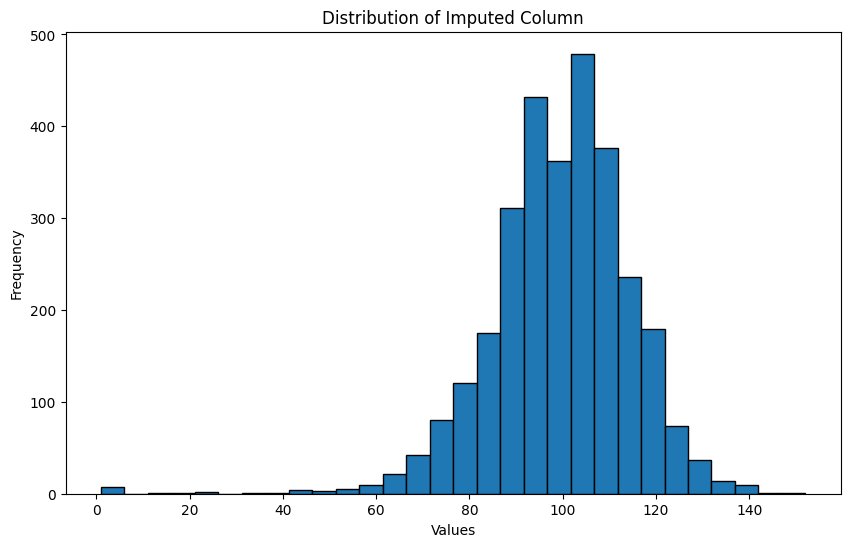

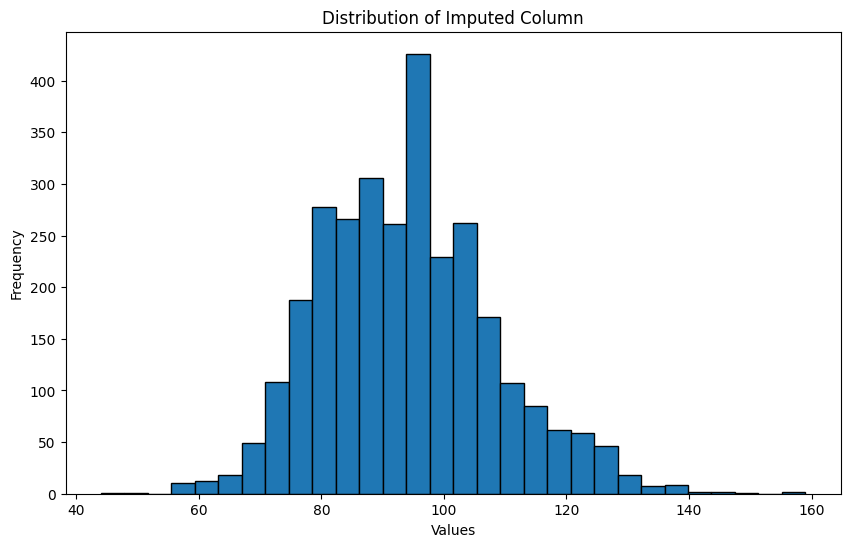

In [77]:
plt.figure(figsize=(10, 6))
plt.hist(df_all['CH5WJ10SS'], bins=30, edgecolor='black')
plt.title('Distribution of Imputed Column')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df_all['CH5PPVTSS'], bins=30, edgecolor='black')
plt.title('Distribution of Imputed Column')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()


In [78]:
assert df_all[['CH5PPVTSS','CH5WJ10SS']].isna().sum().sum() == 0

### Further drop columns withh NA count > 10% 

In [79]:
na_columns_cleaned = df_all.isna().sum()
length = len(df_all)
columns_with_na_cleaned = na_columns_cleaned[na_columns_cleaned > length * 0.1]
columns_to_drop_cleaned = columns_with_na_cleaned.index
df_all = df_all.drop(columns = columns_to_drop_cleaned)
print("droped", len(columns_to_drop_cleaned), "variables, now the shape is", df_all.shape)

droped 971 variables, now the shape is (2985, 1684)


#### Impute na with group mean for all the columns with na left

In [81]:
non_numeric_col = []
for var in df_all.columns.to_list():
    if pd.api.types.is_numeric_dtype(df_all[var]) == False:
        non_numeric_col.append(var)
non_numeric_col.remove('IDNUM')
df_all[non_numeric_col] = df_all[non_numeric_col].apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == 'category' else x)

In [82]:
missing_col_cleaned = df_all.isna().sum()
col_with_na_cleaned = missing_col_cleaned[missing_col_cleaned > 0].index.to_list()
for var in col_with_na_cleaned:
    df_all[var] = df_all.groupby(['CK7EDU'])[var].transform(lambda x: x.fillna(x.median()))

### Dataset cleaning completed

In [87]:
df_all_cleaned = df_all.dropna() ### there's no missing variables, dropna() just in case
df_all_cleaned.shape

(2985, 1684)

In [86]:
assert df_all_cleaned.isna().sum().sum() == 0

In [88]:
df_all_cleaned.to_csv('df_cleaned_final.csv', index = False)

# Model

### Get target variable 

In [89]:
y12 = df_all_cleaned['CK7EDU']
X12 = df_all_cleaned.drop(columns = ['CK7EDU','IDNUM'])

### Random Forest

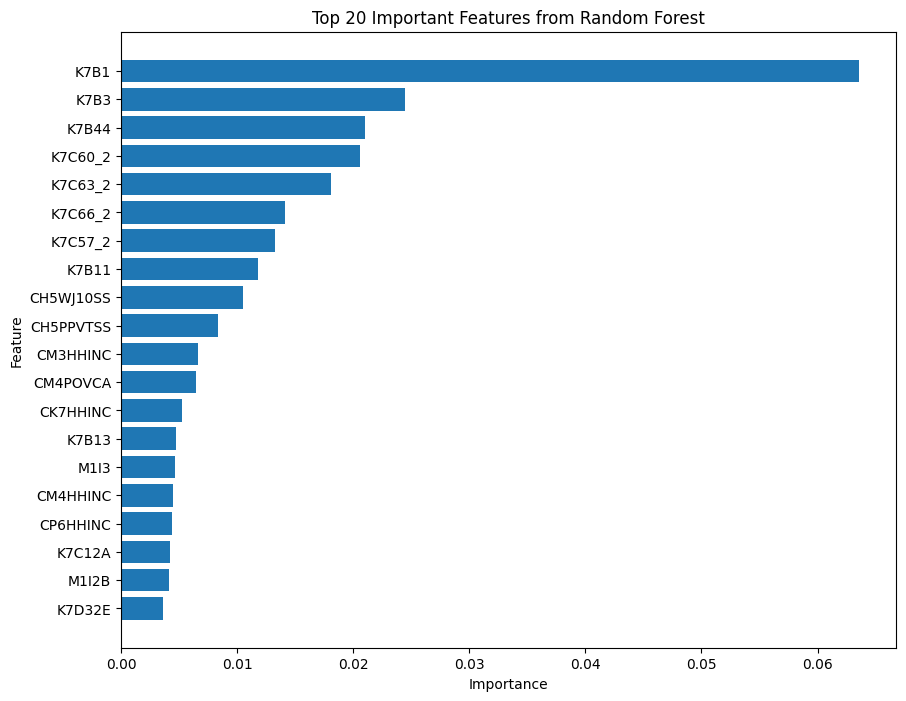

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 70}
Accuracy: 0.9061976549413735
Precision: 0.9082870418319847
Recall: 0.9061976549413735
F1 Score: 0.9060755881067116

Classification Report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        67
         2.0       0.86      0.93      0.89       238
         3.0       0.91      0.84      0.87       229
         4.0       1.00      0.97      0.98        63

    accuracy                           0.91       597
   macro avg       0.94      0.93      0.94       597
weighted avg       0.91      0.91      0.91       597

CPU times: total: 1min 25s
Wall time: 2min


In [90]:
%%time

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X12, y12, test_size=0.2, random_state=0)

X_train.reset_index(inplace = True, drop = True)
y_train = y_train.reset_index(drop = True)
X_test.reset_index(inplace = True, drop = True)
y_test = y_test.reset_index(drop = True)
X_train.shape, y_train.shape

# Initialize and fit Random Forest for feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances
importance_scores = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_scores})

# Sort features by importance score
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Select important features 
IMPORTANCE_CONSTANT = 0.005
selected_features = feature_importances[feature_importances['Importance'] > IMPORTANCE_CONSTANT]['Feature']

top_20_features = feature_importances.head(20)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Important Features from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()


# Redefine X_train and X_test with only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

param_grid = {
    'n_estimators': np.arange(10, 81, 10),  # Number of trees
    'max_depth': [None, 5, 10, 15, 20,25],  # Depth of trees
    'min_samples_split': [2, 5, 10]  # Minimum samples for node split
}

# Grid Search for hyperparameter tuning
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid, 
                           scoring='f1_weighted', 
                           cv=5, verbose=1)

grid_search.fit(X_train_selected, y_train)

# Best parameters and model evaluation
best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Make predictions and evaluate the model
y_pred = best_rf_model.predict(X_test_selected)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [91]:
feature_importances_rf = feature_importances.sort_values(by = 'Importance', ascending=False)
feature_importances_rf.to_csv('f_i_rf_final.csv',index = False)

## Model Comparison

### XGBoost


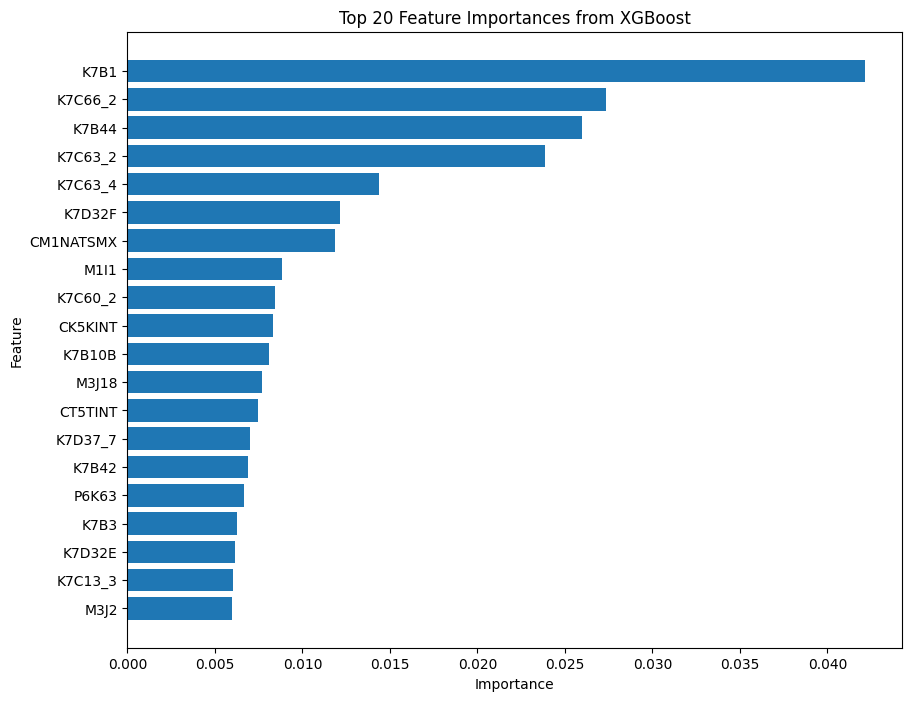

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Accuracy: 0.897822445561139
Precision: 0.8992225277330047
Recall: 0.897822445561139
F1 Score: 0.8976147188885759

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        67
         1.0       0.85      0.91      0.88       238
         2.0       0.90      0.83      0.86       229
         3.0       1.00      1.00      1.00        63

    accuracy                           0.90       597
   macro avg       0.94      0.93      0.93       597
weighted avg       0.90      0.90      0.90       597

CPU times: total: 8min 54s
Wall time: 42.7 s


In [93]:
%%time

# Train-test split
y12_xgb = y12 - 1 ## for xgboost y, need to encode starting from 0
X_train, X_test, y_train, y_test = train_test_split(X12, y12_xgb, test_size=0.2, random_state=0)

X_train.reset_index(inplace = True, drop = True)
y_train = y_train.reset_index(drop = True)
X_test.reset_index(inplace = True, drop = True)
y_test = y_test.reset_index(drop = True)
X_train.shape, y_train.shape


# Train an initial XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Extract feature importances
importance_scores = xgb_model.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_scores})

# Sort features by importance score
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
# print(feature_importances)

# Plotting feature importances 
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'][:20], feature_importances['Importance'][:20])  # Top 20 features
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances from XGBoost')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

# IMPORTANCE_CONSTANT is defined the same as in Random Forest
# Select important features 
selected_features = feature_importances[feature_importances['Importance'] > IMPORTANCE_CONSTANT]['Feature']  # You can adjust the threshold

# Redefine the training and testing sets with only the selected important features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Fine-tuning with GridSearchCV on the selected features
param_grid = {
    'n_estimators': [50, 100],  # Reducing number of trees to control overfitting and speed up training
    'max_depth': [3, 5],  # Limiting depth to avoid overfitting with many features
    'learning_rate': [0.01, 0.1, 0.2],  # Covering low to moderately high learning rates
    'subsample': [0.7, 0.8, 1.0],  # Subsampling to prevent overfitting
    'colsample_bytree': [0.7, 0.8, 1.0],  # Controlling the number of features used per tree
}

# n_estimators: Too many trees can lead to overfitting, especially with many features. Fewer trees keep the model simpler and faster.
# max_depth: Limits how deep the trees go. Deeper trees are more prone to overfitting with high-dimensional data (many features).
# learning_rate: A lower learning rate ensures gradual updates, preventing the model from converging too quickly and missing optimal solutions.
# subsample: Introduces randomness by using only a portion of the training data, which improves generalization.
# colsample_bytree: By using a subset of features per tree, the model avoids becoming too dependent on any one feature, thus reducing overfitting risks.
    
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42), 
                           param_grid=param_grid, scoring='f1_weighted', cv=5, verbose=1)
grid_search.fit(X_train_selected, y_train)

# Best parameters
best_xgb_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predictions
y_pred = best_xgb_model.predict(X_test_selected)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [94]:
feature_importances_xgb = feature_importances.sort_values(by = 'Importance', ascending=False)
feature_importances_xgb.to_csv('f_i_xgb_final.csv',index = False)

'CK5KINT': Constructed -- Did child complete year 9 child survey

'M4H3': If needed help during next yr, could you count on someone to loan you $200? --70.9% YES, 12.6% NO

XGBOOST: low interpretability

We choose to use RF for its speed and intepretability. Random Forest also performs better with an F1 = 0.91 than XGBoost for this task.

## Feature Importance

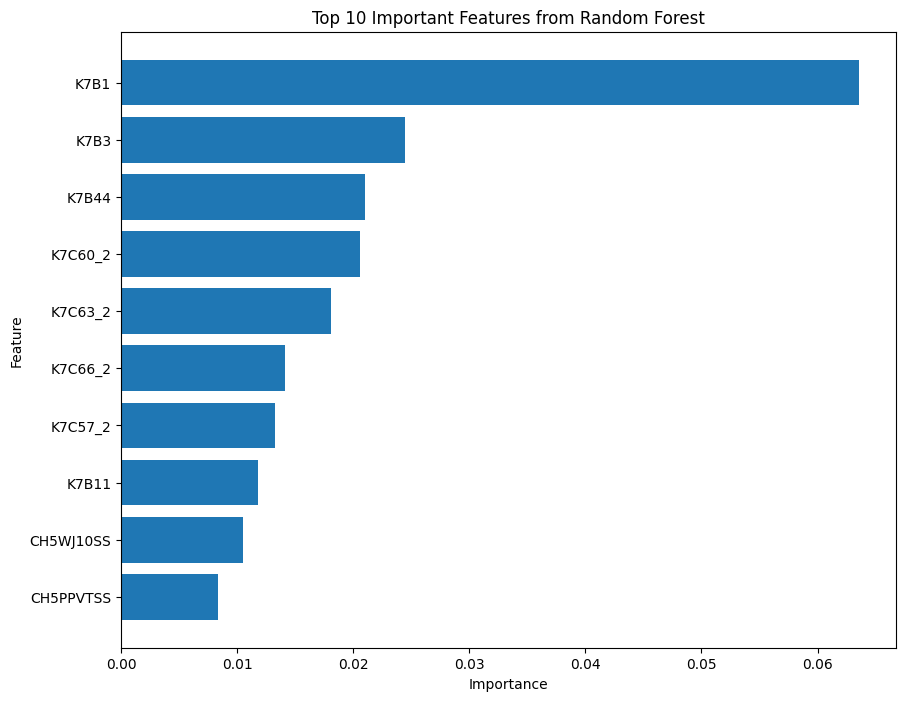

In [95]:
top_10_features_rf = feature_importances_rf.head(10)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_10_features_rf['Feature'], top_10_features_rf['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

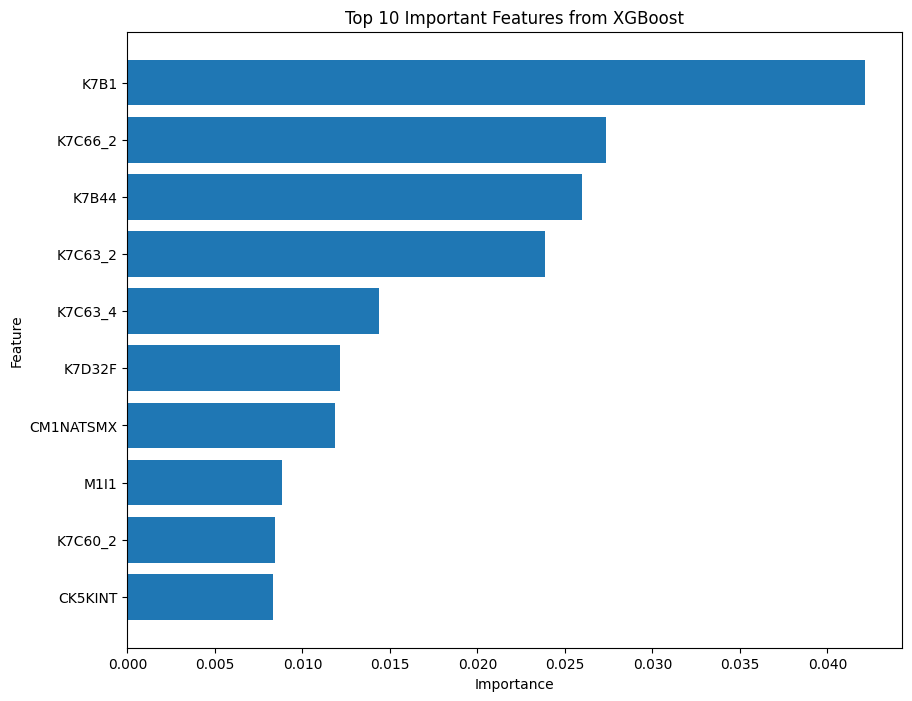

In [96]:
top_10_features_xgb = feature_importances_xgb.head(10)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_10_features_xgb['Feature'], top_10_features_xgb['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features from XGBoost')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()